In [2]:
import multimodal_cci as mmcci
import scanpy as sc
import numpy as np
from matplotlib import pyplot as plt

#### Load stLearn data objects

In [3]:
visium = [
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis1_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis2_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis3_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis4_cci.h5ad")
]

xenium = [
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium1_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium2_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium3_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium4_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium5_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium6_cci.h5ad")
]

cosmx = [
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx0_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx1_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx2_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx3_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx4_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx5_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx6_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx7_cci.h5ad")
]

visium_cci = [sample.uns['per_lr_cci_cell_type'] for sample in visium]
xenium_cci = [sample.uns['per_lr_cci_cell_type'] for sample in xenium]
cosmx_cci = [sample.uns['per_lr_cci_cell_type'] for sample in cosmx]

visium_sizes = [sample.shape[0] for sample in visium]
xenium_sizes = [sample.shape[0] for sample in xenium]
cosmx_sizes = [sample.shape[0] for sample in cosmx]

In [4]:
colors = {
    'Endothelial': plt.colormaps.get_cmap('tab20').colors[0],
    'Fibroblast': plt.colormaps.get_cmap('tab20').colors[1],
    'KC Differentiating': plt.colormaps.get_cmap('tab20').colors[2],
    'KC Cycling': plt.colormaps.get_cmap('tab20').colors[3],
    'KC Basal': plt.colormaps.get_cmap('tab20').colors[4],
    'KC Other': plt.colormaps.get_cmap('tab20').colors[5],
    'NK + T': plt.colormaps.get_cmap('tab20').colors[6],
    'B + PDC': plt.colormaps.get_cmap('tab20').colors[7],
    'Melanocyte': plt.colormaps.get_cmap('tab20').colors[8],
    'Myeloid': plt.colormaps.get_cmap('tab20').colors[9],
    'Pilosebaceous': plt.colormaps.get_cmap('tab20').colors[10]
}

In [5]:
cell_type_replacements = {
    'KC.Basal': 'KC Basal',
    'KC_Basal': 'KC Basal',
    'KC.Cycling': 'KC Cycling',
    'KC_Cyc': 'KC Cycling',
    'KC_Diff': 'KC Differentiating',
    'KC_Other': 'KC Other',
    'NK.T': 'NK + T',
    'B.PDC': 'B + PDC',
    'B...PDC': 'B + PDC',
}
for i in range(len(visium_cci)):
    for lr_pair in visium_cci[i].keys():
        visium_cci[i][lr_pair].rename(
            index=cell_type_replacements,
            columns=cell_type_replacements,
            inplace=True)

for i in range(len(xenium_cci)):
    for lr_pair in xenium_cci[i].keys():
        xenium_cci[i][lr_pair].rename(
            index=cell_type_replacements,
            columns=cell_type_replacements,
            inplace=True)

for i in range(len(cosmx_cci)):
    for lr_pair in cosmx_cci[i].keys():
        cosmx_cci[i][lr_pair].rename(
            index=cell_type_replacements,
            columns=cell_type_replacements,
            inplace=True)

#### Normalise each group of samples

In [6]:
visium_normalised = mmcci.it.normalise_within_tech(visium_cci, visium_sizes, target=visium_sizes[0])
xenium_normalised = mmcci.it.normalise_within_tech(xenium_cci, xenium_sizes, target=xenium_sizes[0])
cosmx_normalised = mmcci.it.normalise_within_tech(cosmx_cci, cosmx_sizes, target=cosmx_sizes[0])

#### Integrate Patients

- 6747: vis4, cosmx1
- 21031: vis2, cosmx2, cosmx3
- 48974: vis1, cosmx4, cosmx5, cosmx6
- 66487: vis3, cosmx7, cosmx8



In [7]:
p6747 = {
    'vis': [visium_normalised[3]],
    'cos': [cosmx_normalised[0]],
}

p21031 = {
    'vis': [visium_normalised[1]],
    'cos': [cosmx_normalised[1], cosmx_normalised[2]],
}

p48974 = {
    'vis': [visium_normalised[0]],
    'cos': [cosmx_normalised[3], cosmx_normalised[4], cosmx_normalised[5]],
}

p66487 = {
    'vis': [visium_normalised[2]],
    'cos': [cosmx_normalised[6], cosmx_normalised[7]],
}

patients = {"6747": p6747, "21031": p21031, "48974": p48974, "66487": p66487}

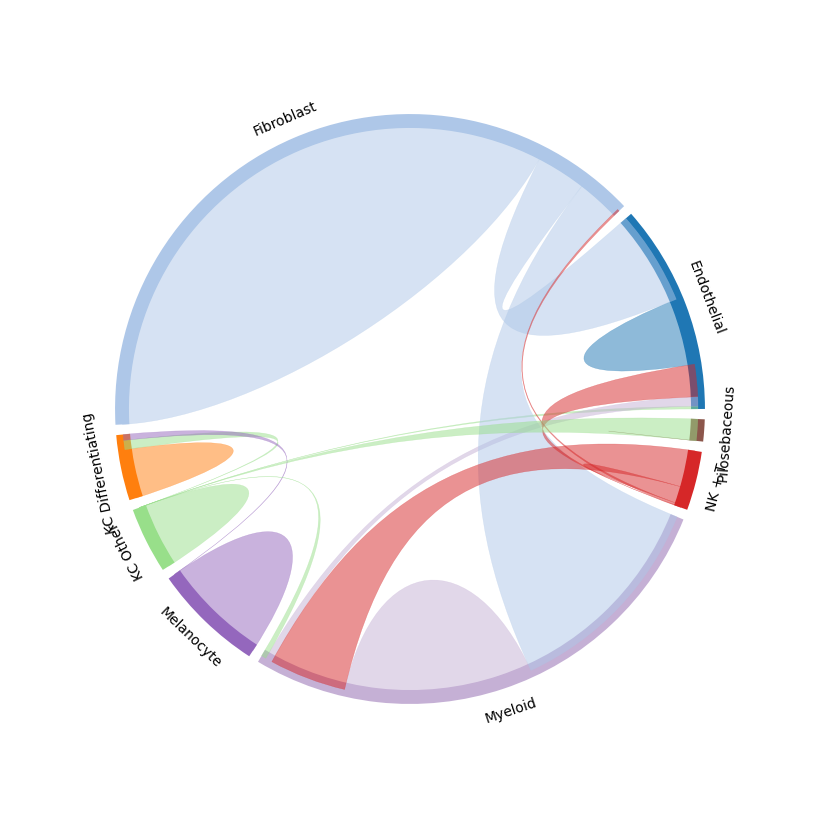

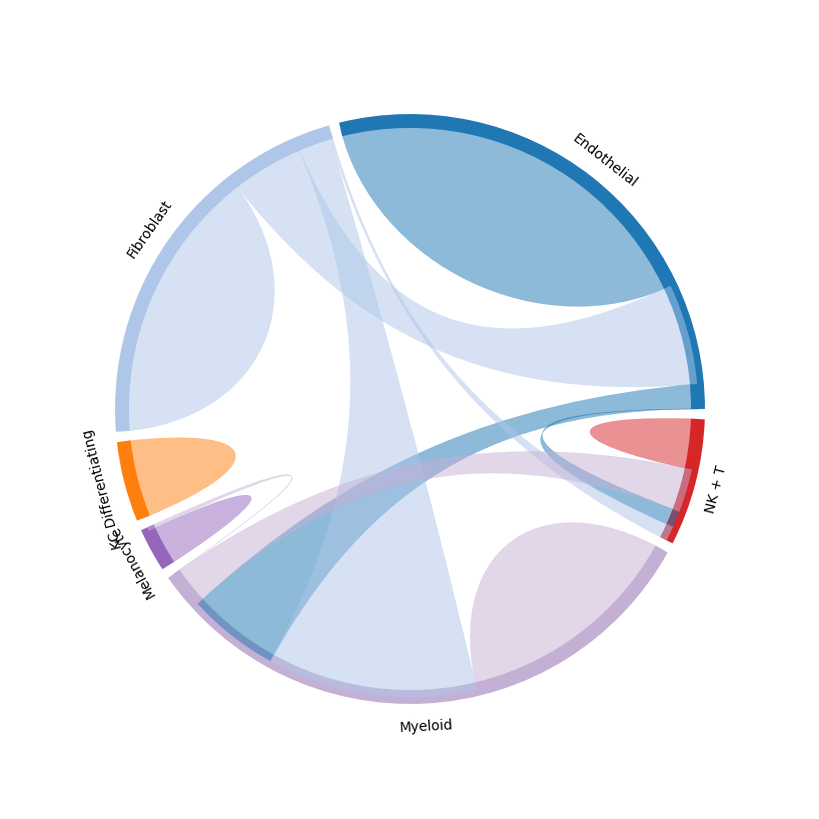

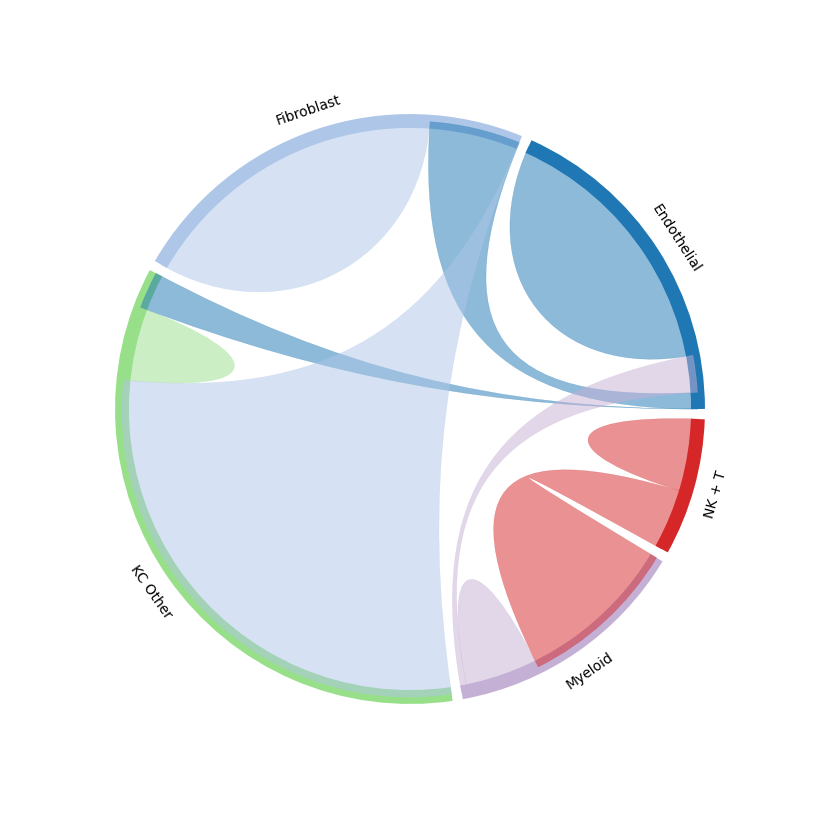

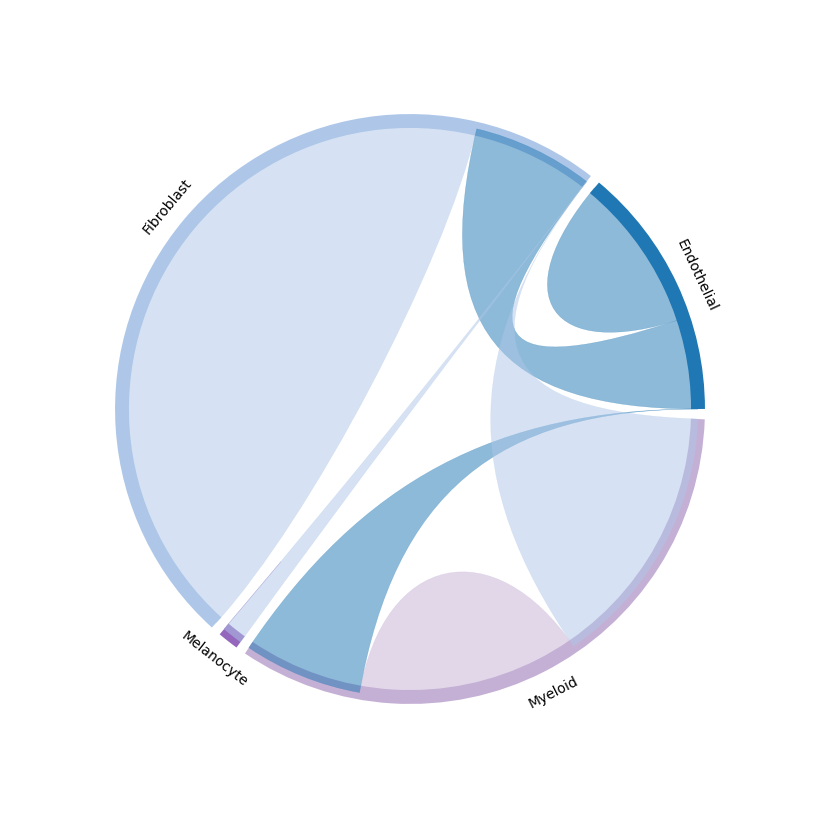

In [8]:
patient_integrated = {}

for patient, samples in patients.items():
    for tech in patients[patient].keys():
        if len(samples[tech]) >= 2:
            samples[tech] = mmcci.it.integrate_samples(samples[tech])
        else:
            samples[tech] = samples[tech][0]
    normalised = mmcci.it.normalise_between_tech([samples['vis'], samples['cos']])
    integrated = mmcci.it.integrate_samples(normalised)
    overall = mmcci.it.calculate_overall_interactions(integrated)
    mmcci.plt.chord_plot(overall, colors=colors)
    # mmcci.plt.network_plot(overall)
    patient_integrated[patient] = integrated

#### Integrate Patients Together

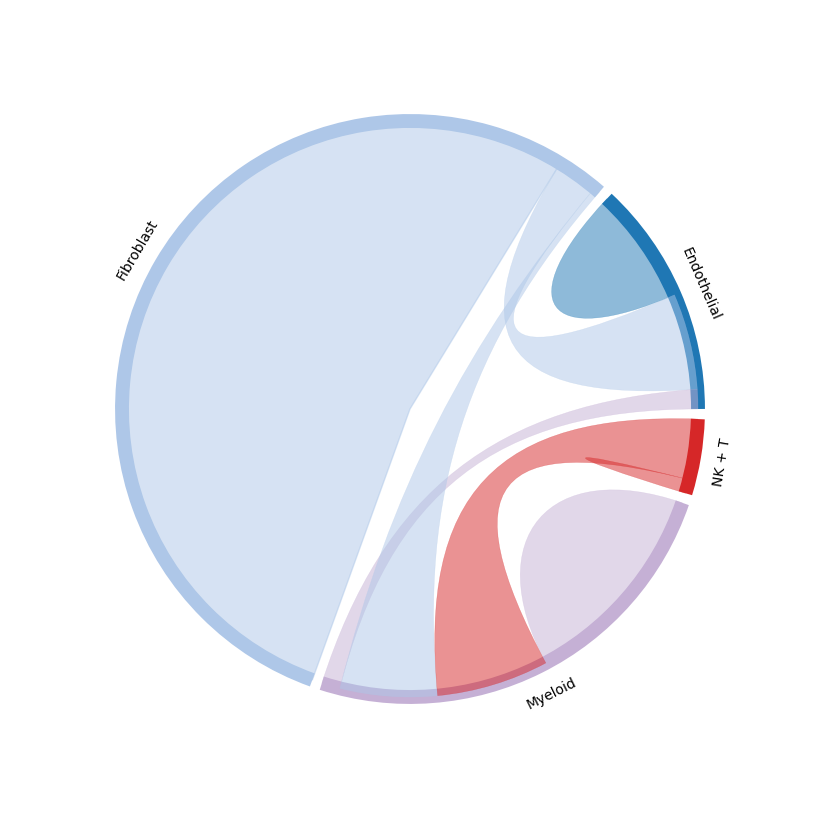

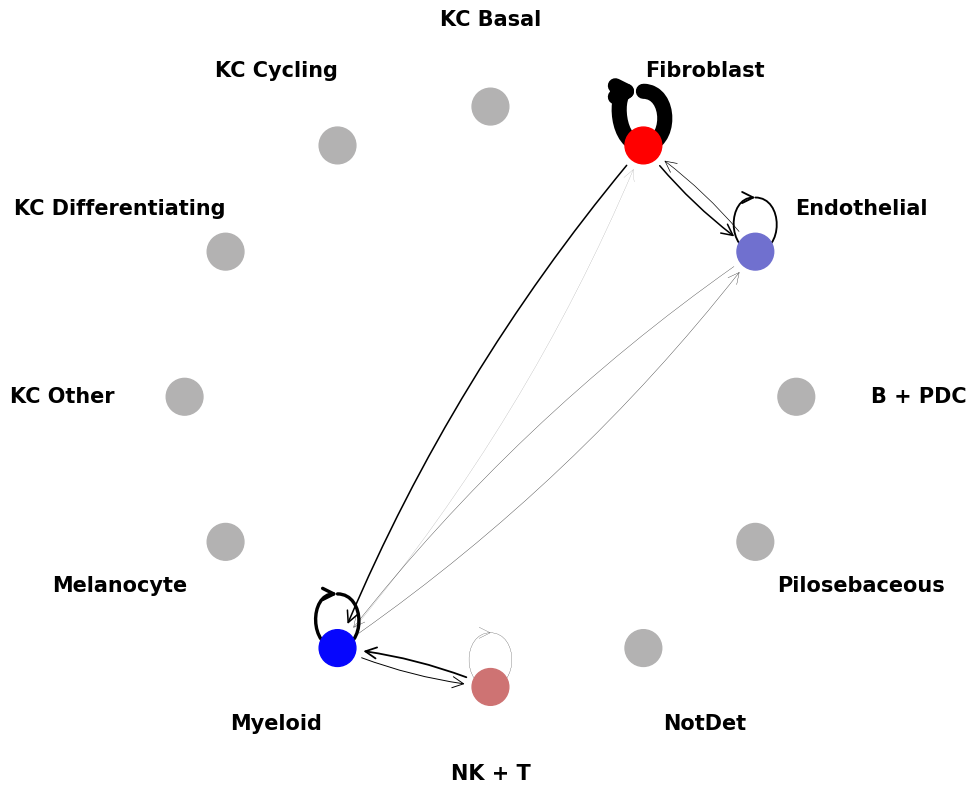

In [9]:
normalised = mmcci.it.normalise_between_tech(
    [patient_integrated['6747'], patient_integrated['21031'], patient_integrated['48974'], patient_integrated['66487']]
    )

integrated = mmcci.it.integrate_samples(normalised)
overall = mmcci.it.calculate_overall_interactions(integrated)

mmcci.plt.chord_plot(overall, colors=colors)
mmcci.plt.network_plot(overall)

#### Integrate within tech

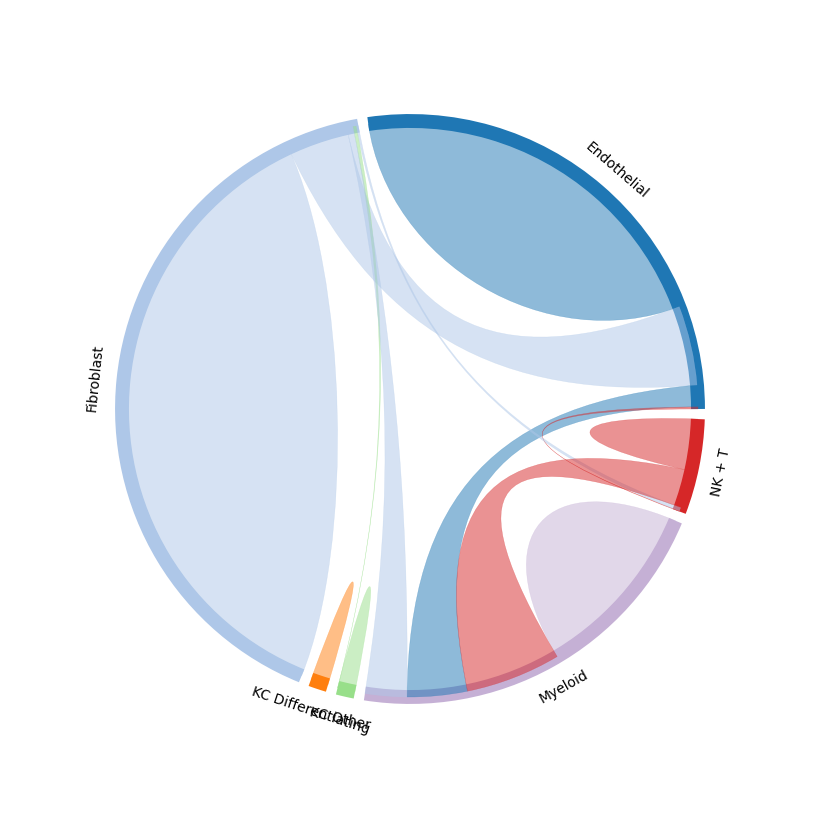

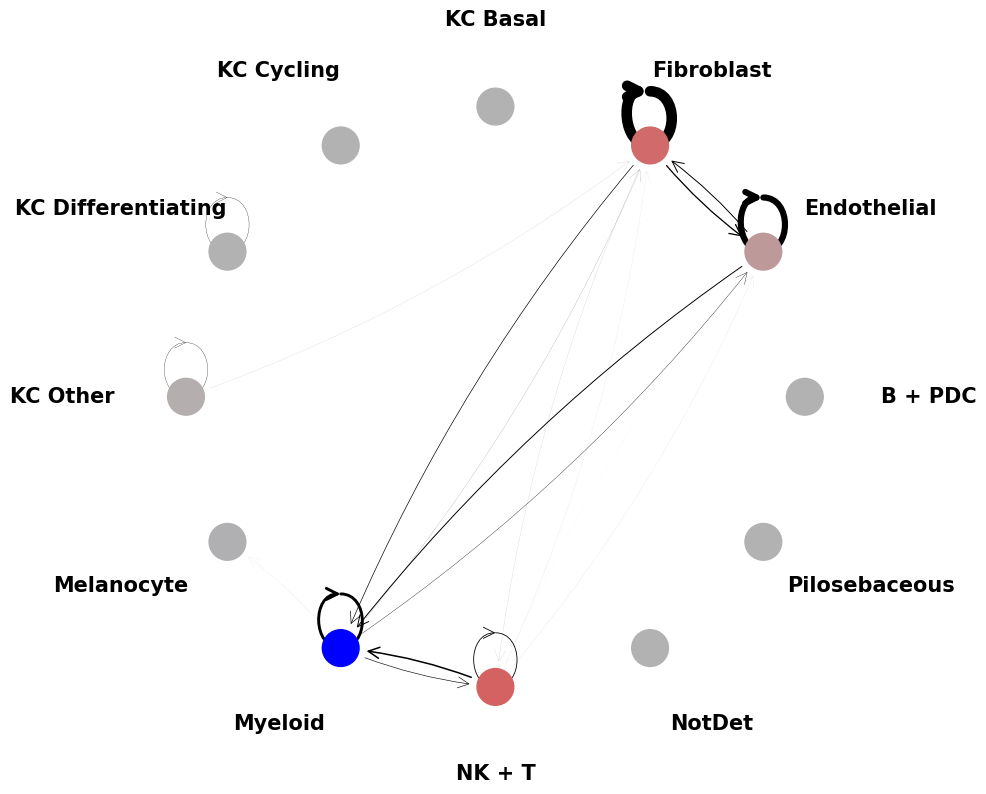

In [10]:
integrated = {}
overall = {}

for tech, samples in zip(['vis', 'xen', 'cos'], [visium_normalised, xenium_normalised, cosmx_normalised]):
    integrated[tech] = mmcci.it.integrate_samples(samples)
    overall[tech] = mmcci.it.calculate_overall_interactions(integrated[tech])
    # mmcci.plt.chord_plot(overall[tech], colors=colors)
    # mmcci.plt.network_plot(overall[tech])
    
normalised = mmcci.it.normalise_between_tech(
    [integrated['vis'], integrated['xen'], integrated['cos']]
    )

integrated = mmcci.it.integrate_samples(normalised)
overall = mmcci.it.calculate_overall_interactions(integrated)

mmcci.plt.chord_plot(overall, colors=colors)
mmcci.plt.network_plot(overall)

#### Get LR pairs from Fibroblast to Fibroblast

In [13]:
Fibroblast_Fibroblast = mmcci.an.get_lrs_per_celltype(integrated, "Fibroblast", "Fibroblast")
print("LR pairs from Fibroblast to Fibroblast")
print(Fibroblast_Fibroblast)

LR pairs from Fibroblast to Fibroblast
{'COL1A1_CD44': 0.16562224771818645, 'COL1A1_ITGB1': 0.10736484467528366, 'COL1A2_CD44': 0.08578593145261426, 'COL1A2_ITGB1': 0.07777367197928246, 'COL1A1_DDR1': 0.07236513725996983, 'COL1A1_ITGA5': 0.06525866056091571, 'COL3A1_DDR1': 0.05478809537495079, 'COL1A1_CD36': 0.051745397912823815, 'COL1A1_DDR2': 0.030673682542872963, 'COL3A1_DDR2': 0.02854972152584414, 'DCN_EGFR': 0.028056200135635923, 'DCN_TLR4': 0.025387623330836516, 'DCN_TLR2': 0.020467771880089424, 'COL1A1_ITGA2': 0.016098271296183003, 'FN1_ITGB1': 0.013217419421304413, 'COL1A2_ITGA2': 0.012621233964015145, 'CXCL12_ACKR3': 0.011158652397295096, 'FBLN1_ITGB1': 0.010493912941661961, 'FN1_ITGA5': 0.010160240572730836, 'VIM_CD44': 0.009291750195337343, 'CXCL12_ITGAV': 0.00916109183876701, 'CXCL12_ITGB1': 0.00781434010529401, 'CXCL14_CXCR4': 0.007135701176747295, 'FN1_CD44': 0.007080873111608483, 'DCN_MET': 0.006658981037327862, 'FN1_ITGAV': 0.0064285418807618665, 'GAS6_AXL': 0.006030158

In [17]:
integrated.keys()

dict_keys(['ADAM12_ITGB1', 'ANGPT2_TIE1', 'ANGPTL1_TEK', 'ANXA1_EGFR', 'ANXA2_TLR2', 'APOD_LEPR', 'APP_CAV1', 'APP_CD74', 'APP_TNFRSF21', 'AREG_ERBB3', 'AZGP1_ITGAV', 'BGN_FGFR3', 'BMP2_ENG', 'BMP4_BMPR1A', 'BMP7_ENG', 'C1QA_CD33', 'C1QA_CD93', 'C1QB_CD33', 'CCL19_CCR10', 'CCL19_CCR7', 'CCL19_CCRL2', 'CCL21_CCR7', 'CCL2_ACKR1', 'CCL2_CCR1', 'CCL2_CCR2', 'CCL5_ACKR1', 'CCL5_CCR1', 'CCL8_ACKR1', 'CD14_ITGB1', 'CD209_ICAM3', 'CD84_CD84', 'COL14A1_CD44', 'COL18A1_ITGA5', 'COL18A1_ITGB1', 'COL18A1_KDR', 'COL1A1_CD36', 'COL1A1_CD44', 'COL1A1_DDR1', 'COL1A1_DDR2', 'COL1A1_ITGA2', 'COL1A1_ITGA5', 'COL1A1_ITGB1', 'COL1A2_CD44', 'COL1A2_ITGA2', 'COL1A2_ITGB1', 'COL3A1_DDR1', 'COL3A1_DDR2', 'COL4A1_ITGA1', 'COL4A1_ITGB1', 'COL5A2_DDR1', 'COL8A1_ITGA1', 'CSF1_CSF1R', 'CX3CL1_ITGAV', 'CXCL12_ACKR3', 'CXCL12_CD4', 'CXCL12_CXCR3', 'CXCL12_CXCR4', 'CXCL12_ITGA5', 'CXCL12_ITGAV', 'CXCL12_ITGB1', 'CXCL14_CXCR4', 'DCN_EGFR', 'DCN_MET', 'DCN_TLR2', 'DCN_TLR4', 'EFNA5_EPHA2', 'EFNA5_EPHA3', 'EFNA5_EPHA4', 

#### Cluster Aged and Young LR Pairs

In [14]:
clusters = mmcci.an.lr_grouping(integrated, n_clusters=0)
integrated_clusters = mmcci.an.subset_clusters(integrated, clusters)
overall_clusters = mmcci.an.calculate_cluster_interactions(integrated_clusters)

Computing Dissimilarity Scores for multiple interactions...


Processing: 100%|██████████| 53/53 [00:01<00:00, 38.66it/s]


Computing Principal Components of weighted graph ...


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [12]:
for cluster, matrix in overall_clusters.items():
    print("\ncluster" + str(cluster) + ": Contains " + str(len(integrated_clusters[cluster])) + " LR pairs")
    mmcci.plt.network_plot(matrix)

NameError: name 'overall_clusters' is not defined

Computing Dissimilarity Scores for multiple interactions...


Processing: 100%|██████████| 37/37 [00:00<00:00, 71.85it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


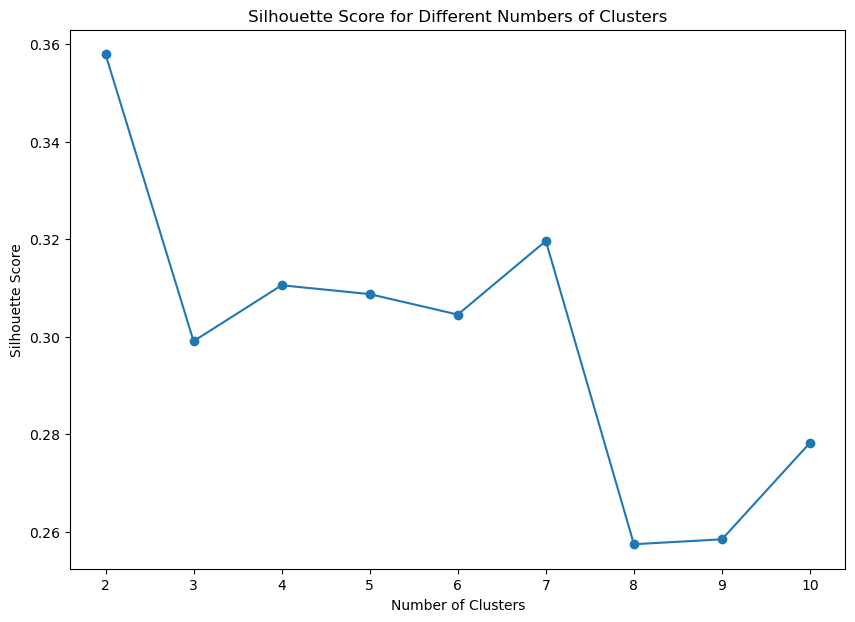

Computing Dissimilarity Scores for single interactions...


Processing: 100%|██████████| 98/98 [00:04<00:00, 22.95it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...


In [ ]:
young_clusters = mmcci.an.lr_grouping(young_integrated, n_clusters=0)
young_integrated_clusters = mmcci.an.subset_clusters(young_integrated, young_clusters)
young_overall_clusters = mmcci.an.calculate_cluster_interactions(young_integrated_clusters)


cluster0: Contains 26 LR pairs


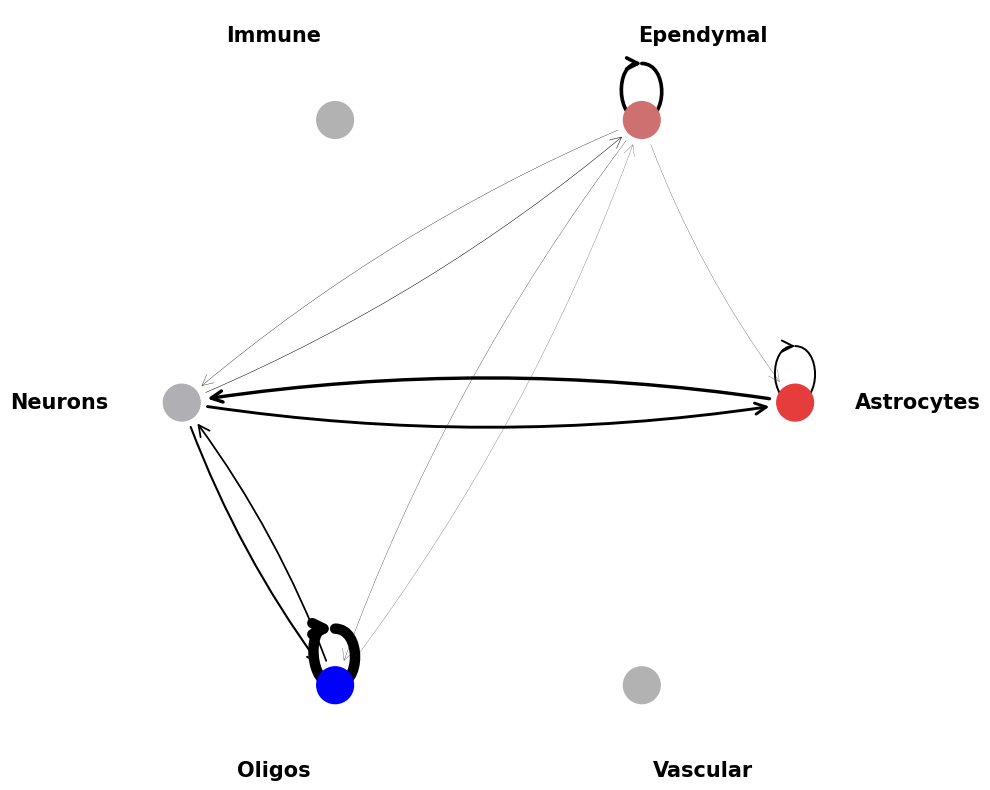


cluster1: Contains 11 LR pairs


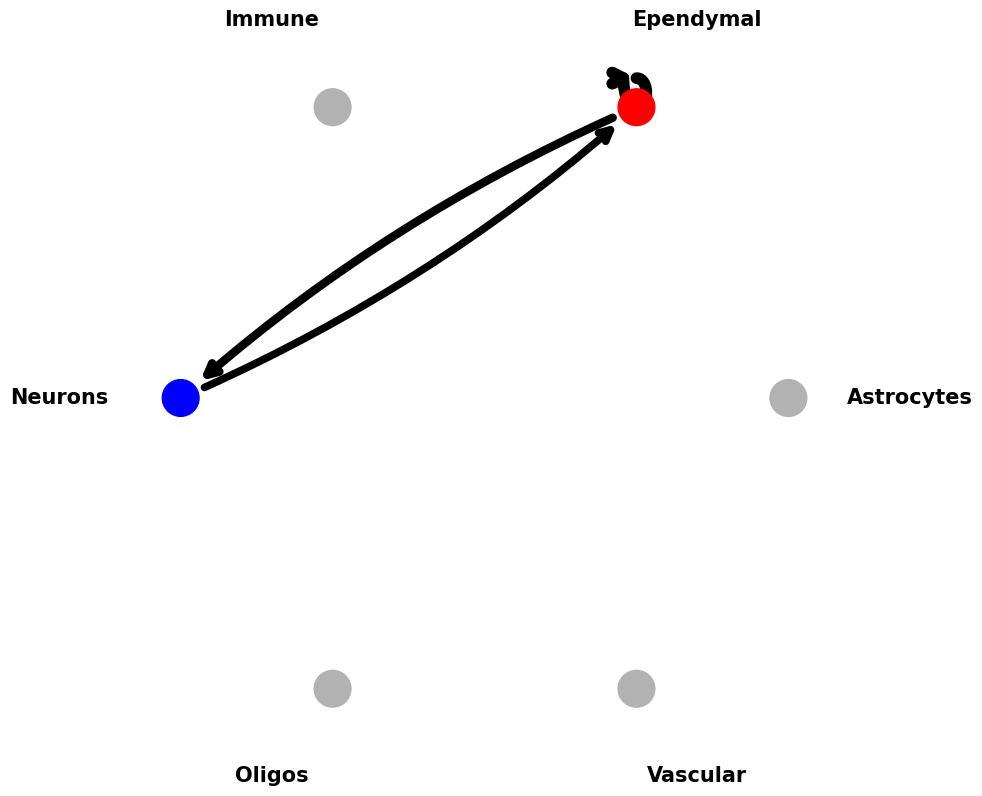


cluster2: Contains 37 LR pairs


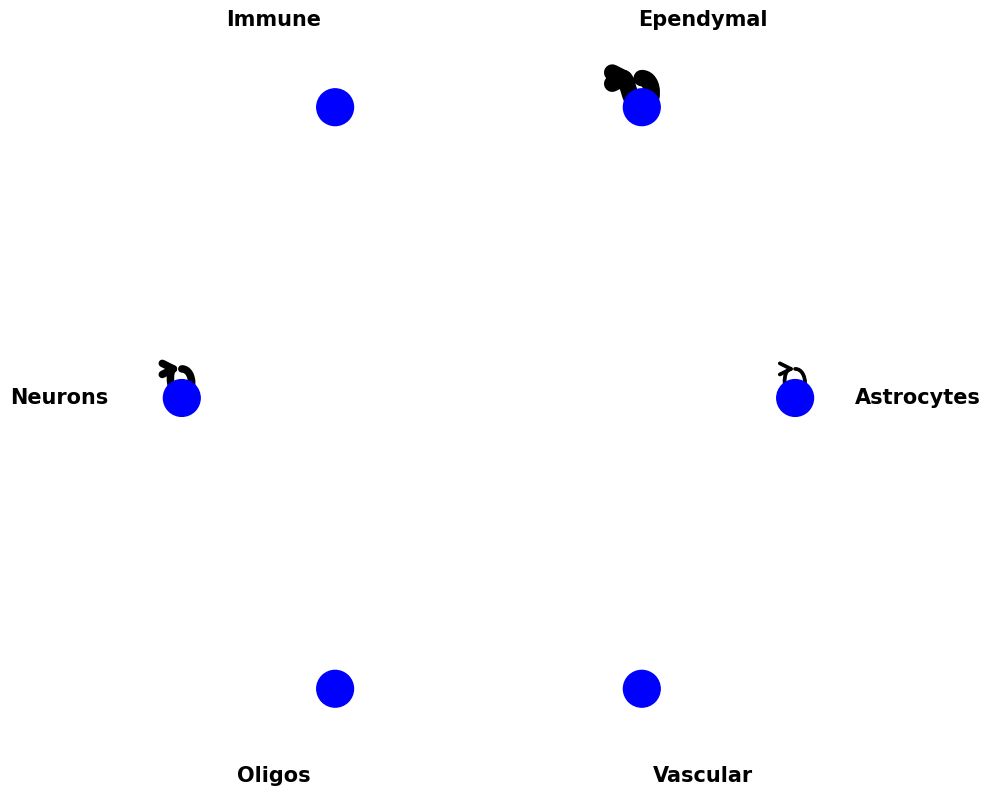


cluster3: Contains 61 LR pairs


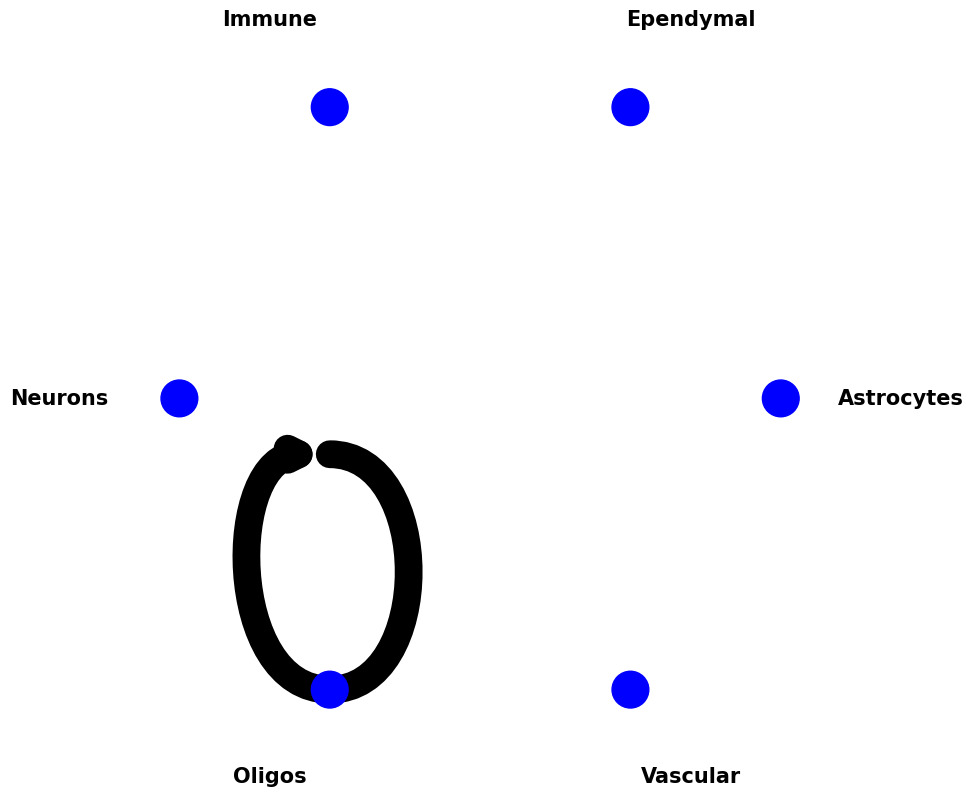

In [ ]:
for cluster, matrix in young_overall_clusters.items():
    if matrix is not None:
        print("\ncluster" + str(cluster) + ": Contains " + str(len(young_integrated_clusters[cluster])) + " LR pairs")
        mmcci.plt.network_plot(matrix)

#### Run GSEA Analysis on Clusters

/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/uqlhocke/micromamba/envs/py-env/lib/python3.9/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,25/200,2.058022e-28,8.026285e-27,0,0,38.081081,2427.693193,NOTCH2;ITGB1;LRP1;SERPINE2;SDC4;LAMA2;LAMA1;FB...
1,MSigDB_Hallmark_2020,Angiogenesis,6/36,2.179519e-08,4.250063e-07,0,0,42.733333,753.883364,LRPAP1;VTN;LPL;ITGAV;VEGFA;FGFR1
2,MSigDB_Hallmark_2020,UV Response Dn,8/144,5.853843e-07,7.609996e-06,0,0,12.776341,183.353240,PDGFRB;COL1A1;NOTCH2;TGFBR3;COL1A2;FZD2;SDC2;CAV1
3,MSigDB_Hallmark_2020,Apoptosis,8/161,1.362950e-06,1.328876e-05,0,0,11.346980,153.250714,PDGFRB;TGFBR3;TGFB2;CAV1;BGN;PLAT;PSEN1;CD44
4,MSigDB_Hallmark_2020,Myogenesis,8/200,6.834697e-06,5.331064e-05,0,0,9.024267,107.330110,COL1A1;ITGB1;TGFB1;NOTCH1;LAMA2;PLXNB2;FGF2;HBEGF
...,...,...,...,...,...,...,...,...,...,...
195,KEGG_2021_Human,Human immunodeficiency virus 1 infection,1/212,6.527138e-01,6.693435e-01,0,0,0.952220,0.406233,GNAI2
196,KEGG_2021_Human,cAMP signaling pathway,1/216,6.596123e-01,6.721366e-01,0,0,0.934314,0.388771,GNAI2
197,KEGG_2021_Human,Thermogenesis,1/232,6.858755e-01,6.945028e-01,0,0,0.868893,0.327624,FGFR1
198,KEGG_2021_Human,Parkinson disease,1/249,7.115841e-01,7.160315e-01,0,0,0.808632,0.275147,GNAI2


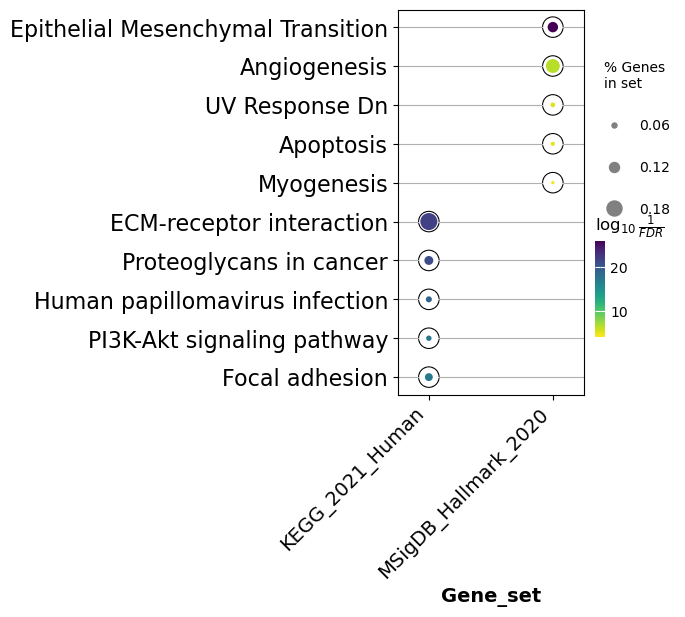

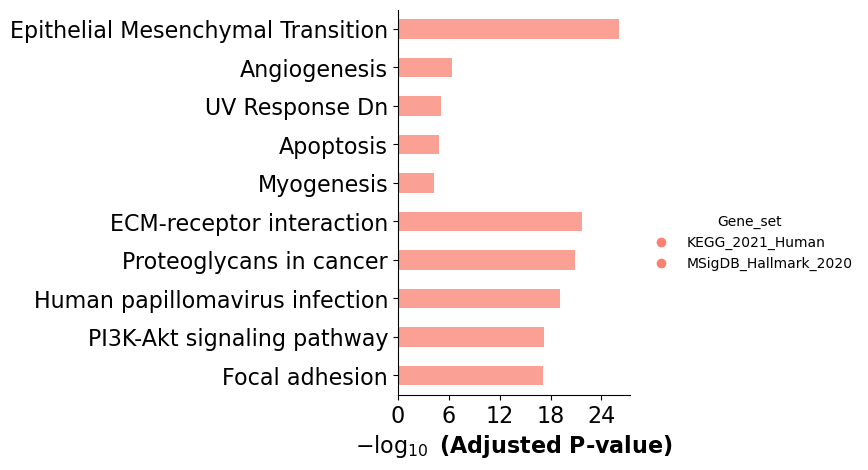

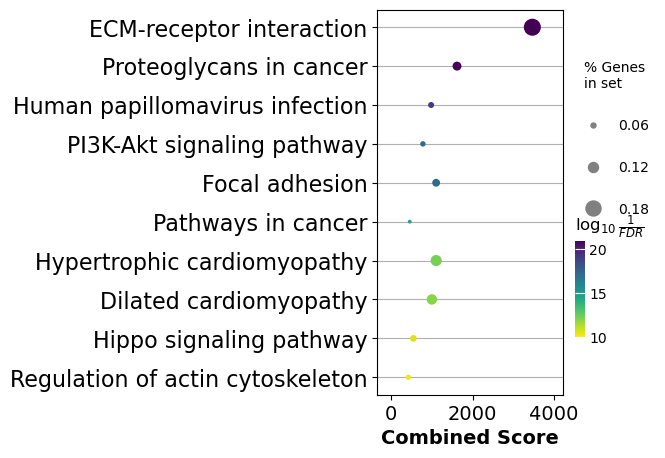

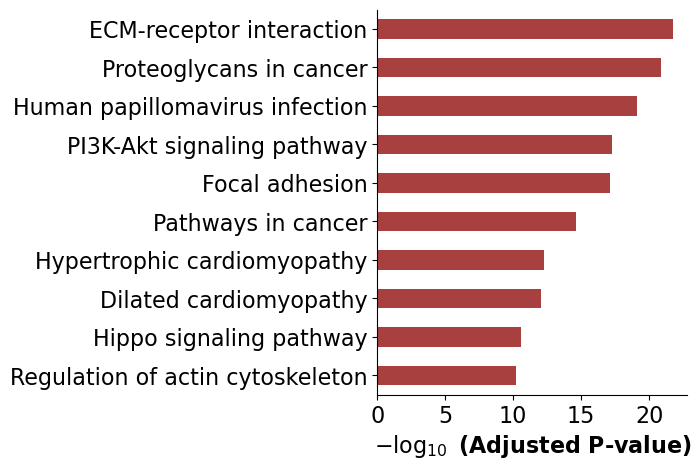

In [ ]:
aged_cluster_0_gsea = mmcci.an.run_gsea(aged_integrated_clusters[0])
aged_cluster_0_gsea